<a href="https://colab.research.google.com/github/eruru0411/git-test/blob/master/Kaggle_bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* datetime - hourly date + timestamp
* season
 -  1 = spring, 2 = summer, 3 = fall, 4 = winter
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather 
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as p
import seaborn as sns
from scipy import stats

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_curve, classification_report, precision_recall_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Binarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

import warnings
warnings.filterwarnings(action="ignore")

# Window 의 한글 폰트 설정
#p.rc('font',family='Malgun Gothic')
p.style.use('ggplot')


# EDA

In [2]:
#1. EDA
#train 데이터 불러오기
train = pd.read_csv("bike_train.csv")
print(train.shape) #(10886, 12)

(10886, 12)


In [3]:
print(train.info()) #null값X, datetime->object 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None


In [4]:
print(train.head())
#count:target data
#casual+registered=count이므로 추후 삭제

              datetime  season  holiday  ...  casual  registered  count
0  2011-01-01 00:00:00       1        0  ...       3          13     16
1  2011-01-01 01:00:00       1        0  ...       8          32     40
2  2011-01-01 02:00:00       1        0  ...       5          27     32
3  2011-01-01 03:00:00       1        0  ...       3          10     13
4  2011-01-01 04:00:00       1        0  ...       0           1      1

[5 rows x 12 columns]


In [5]:
#datetime : object->datetime으로 변경
train["datetime"] = pd.to_datetime(train["datetime"])

In [6]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [7]:
#null값 확인 -> 전부 0
print(train.isnull().sum())

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


# Feature Engineering

In [8]:
#datetime(시계열 데이터)-> 년/월/일/시/분/초/요일로 나누기 + datetime 삭제
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
#train = train.drop(["datetime"],axis=1)

In [9]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Hour'), Text(0.5, 1.0, 'Count By Hour')]

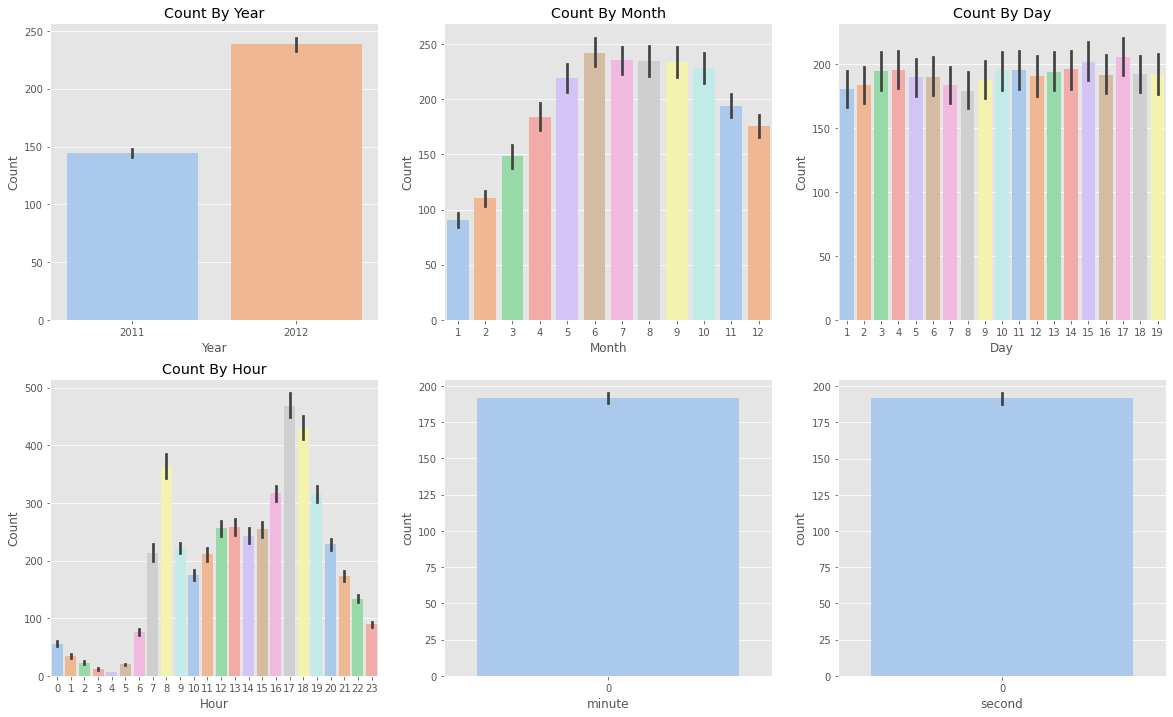

In [10]:
flg, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
flg.set_size_inches(20,12)

sns.barplot(data=train, x="year", y="count",ax=ax1, palette='pastel')
sns.barplot(data=train, x="month", y="count",ax=ax2, palette='pastel')
sns.barplot(data=train, x="day", y="count",ax=ax3, palette='pastel')
sns.barplot(data=train, x="hour", y="count",ax=ax4, palette='pastel')
sns.barplot(data=train, x="minute", y="count",ax=ax5, palette='pastel')
sns.barplot(data=train, x="second", y="count",ax=ax6, palette='pastel')



ax1.set(xlabel='Year', ylabel='Count',title="Count By Year")
ax2.set(xlabel='Month', ylabel='Count',title="Count By Month")
ax3.set(xlabel='Day', ylabel='Count',title="Count By Day")
ax4.set(xlabel='Hour', ylabel='Count', title="Count By Hour")

- 연도별 자전거 대여수를 비교한 결과, 2011년보다 2012년도에 자전거 대여수가 증가하였다.
- 월별 대여량은 6월에 가장 많고, 1월이 가장 적다.
- 시간별로 비교했을 때,  8시-9시, 17시-18시에 대여가 증가하는 것을 확인 할 수 있었다. 이는 출퇴근시간대에 자전거 이용이 활발히 이루어짐을 알 수 있다.
- 일별대여량은 1일~19일까지만 존재함 -> 피쳐로 사용하기 어려워보인다.
- 분, 초는 다 0이므로 피쳐로 사용하기 적합하지 않다.

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Count by Workingday')]

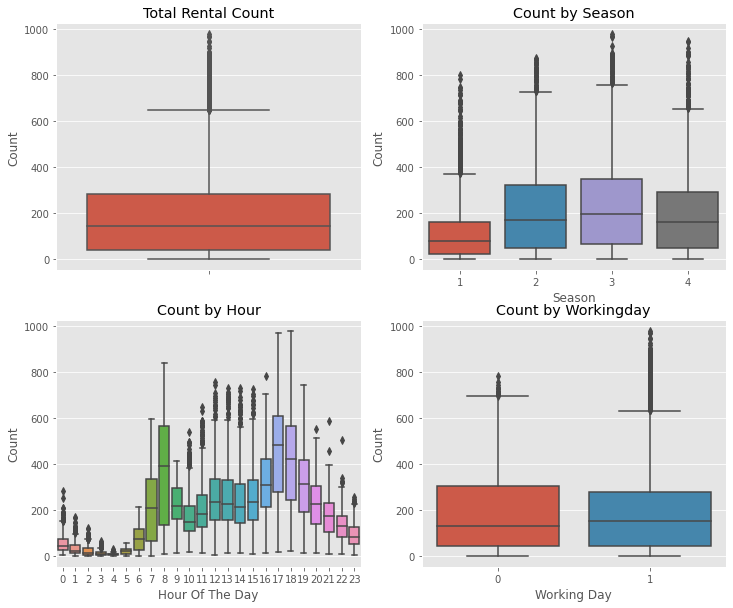

In [11]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Total Rental Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Count by Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Count by Hour")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Count by Workingday")

- 계절별로 봤을때는 봄이 가장 적고 여름, 가을이 가장 많음을 알 수 있다.
- 근무일 여부에 따라서는 휴일인 경우 평일보다 근소하게 대여수가 더 높았다.
- 전반적으로 대여수에 이상치가 많이 발견되어, 모델 분석에 앞서 이상치 제거가 필요해보인다.

In [12]:
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

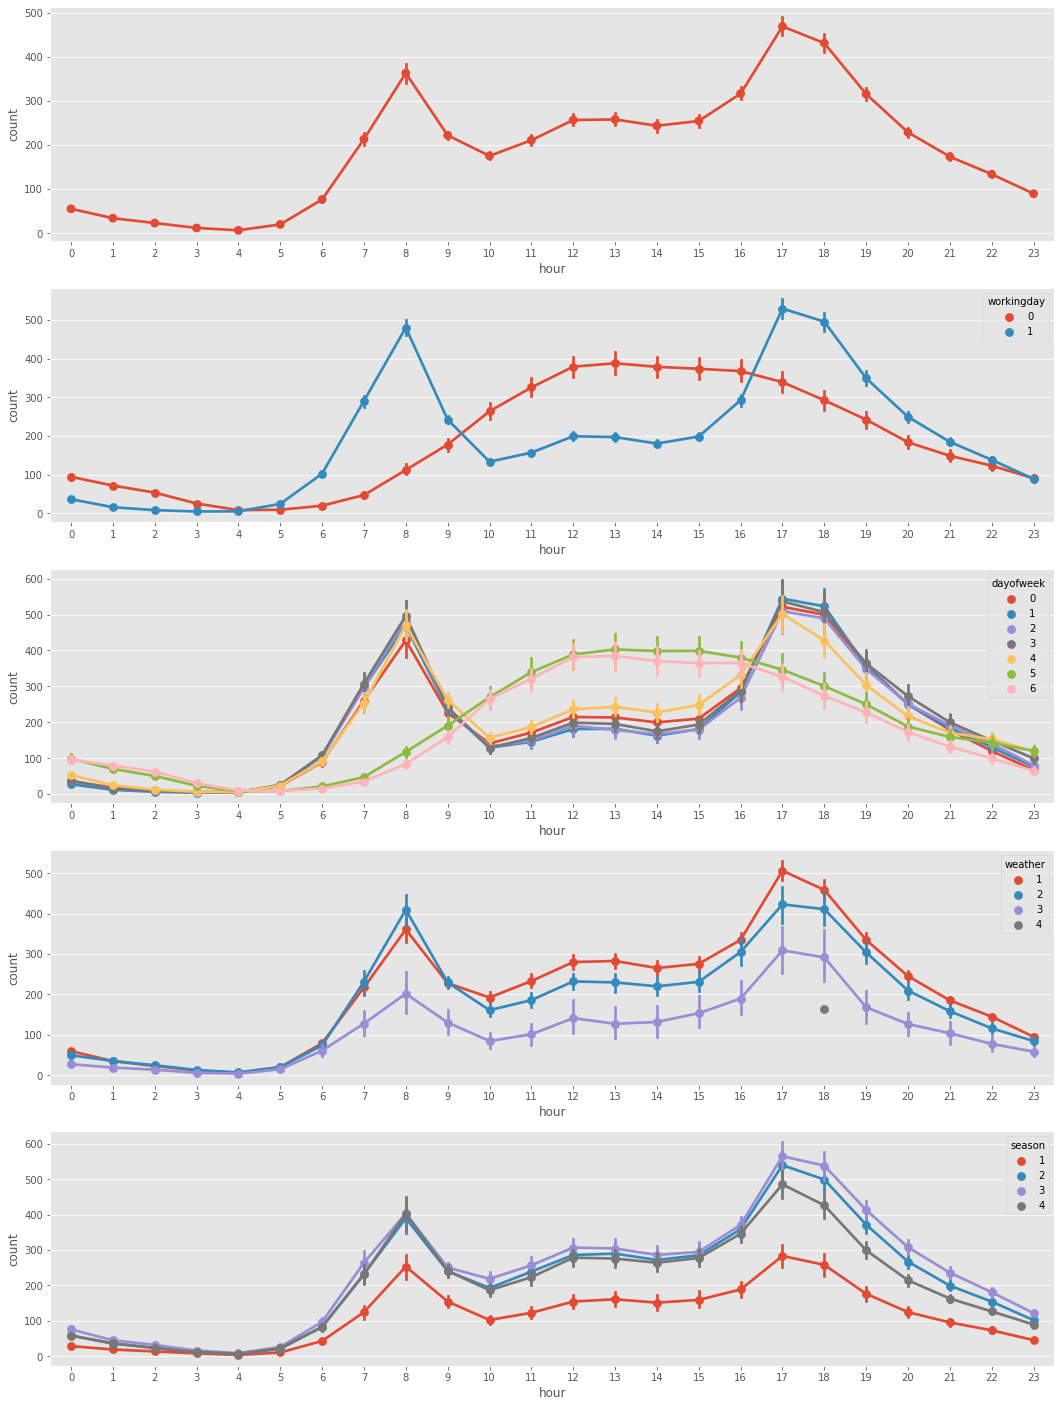

In [13]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=5)
fig.set_size_inches(18,25)

#시간대별 대여량을 근무일/휴일, 날씨, 계절에 따라 비교
sns.pointplot(data=train, x="hour", y="count", ax=ax1)
sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)
sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)
sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)
sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

- workingday : 근무일(1)에는 출퇴근 시간에 대여량이 많고, 휴일에는(0) 점심시간대에 대여량이 높은 것을 알 수 있다.
- dayofweek : workingday 그래프와 유사한 모양을 하고 있으며 0-4는 근무일, 5-6은 휴일인 것을 볼 수 있다. 
- weather :(1:화창, 2:흐림,안개 3:눈/비, 4.심한 눈/비)
 날씨의 경우, 1>2>3>4 순으로 대여수가 높으며, 날씨가 안좋은 4의 경우 대여량이 거의 없다.
- season : (1:봄, 2:여름, 3:가을, 4:겨울) 계절의 경우, 가을>여름>겨울>봄 순으로 대여량이 높았다. 

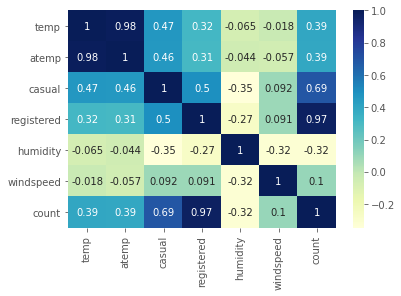

In [14]:
#상관관계 분석
sns.heatmap(train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]].corr(), annot=True, fmt='.2g', cmap='YlGnBu')

- 온도, 습도, 풍속은 거의 연관관계가 없다.
- registered와 count는 가장 상관관계가 크지만, test set에는 존재하지 않아 피처로 사용하기 어렵다.
- atemp와 temp는 0.98로 상관관계가 높지만 다중공선성의 문제로 피처로 사용하기에 적합하지 않아보인다.

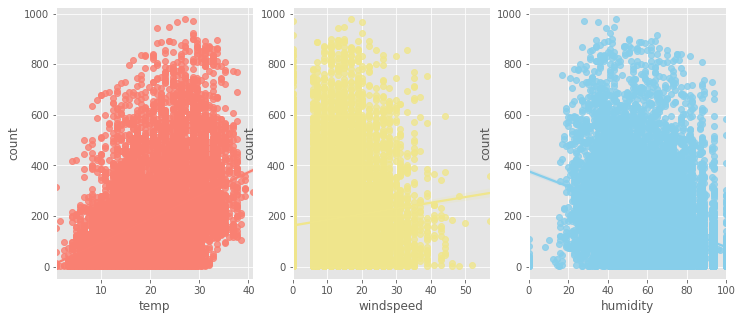

In [15]:
#온도, 풍속, 속도에 따른 상관도
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12,5)
sns.regplot(x="temp", y="count", data=train, ax=ax1, color='salmon')
sns.regplot(x="windspeed", y="count", data=train, ax=ax2, color='khaki')
sns.regplot(x="humidity", y="count", data=train, ax=ax3, color='skyblue')

- 풍속의 경우 0에 숫자가 많이 몰려있으며 feature engineering을 통해 조정이 필요해 보인다.

In [16]:
def concatenate_year_month(datetime) :
  return "{0}-{1}".format(datetime.year, datetime.month)

train["year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "year_month"]].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


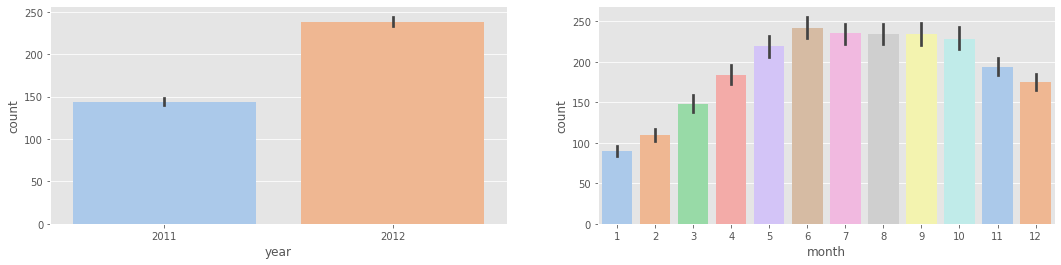

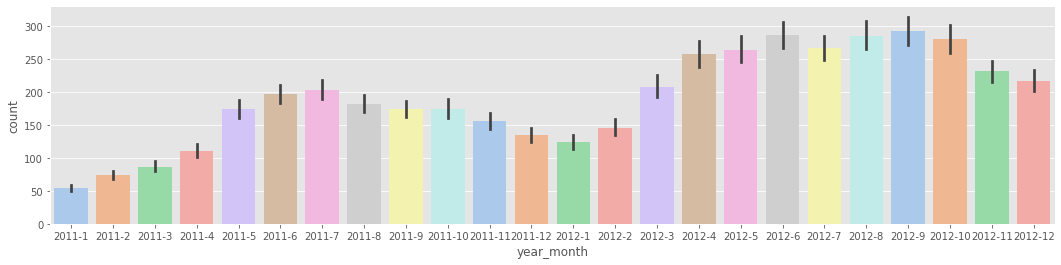

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18,4)

sns.barplot(data=train, x="year", y="count",ax=ax1, palette='pastel')
sns.barplot(data=train, x="month", y="count",ax=ax2, palette='pastel')

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18,4)

sns.barplot(data=train, x="year_month", y="count", ax=ax3, palette='pastel')

- 2011년보다 2012년의 대여량이 더 많으며, 겨울보다 여름에 대여량이 더 많음을 알 수 있다.
- 2011년과 2012년의 월별 데이터를 보면, 전체적으로 증가하는 추세를 보인다.

In [18]:
#count값의 데이터 분포도를 파악
# fig, (ax1, ax2) = plt.subplots(ncols=2)
# fig.set_size_inches(12,10)

# sns.distplot(train["count"], ax=ax1)
# stats.probplot(train["count"], dist='norm', fit=True, plot=ax2)

In [45]:
#이상치
# trainWithoutOutliers
trainWithoutOutliers = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909617))

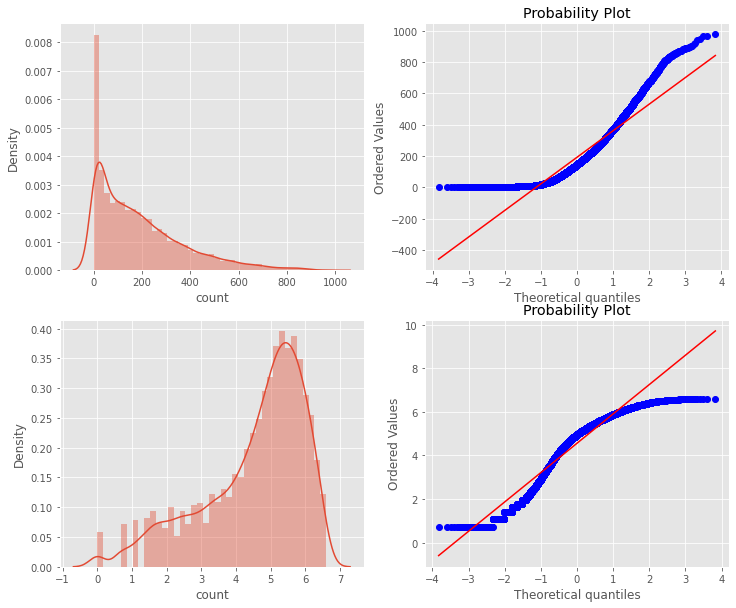

In [46]:
# count값의 데이터 분포도를 파악

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

- count변수가 오른쪽에 치우쳐져 있다. 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직하다. 

In [20]:
#test data 불러오기
test = pd.read_csv("bike_test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

In [21]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

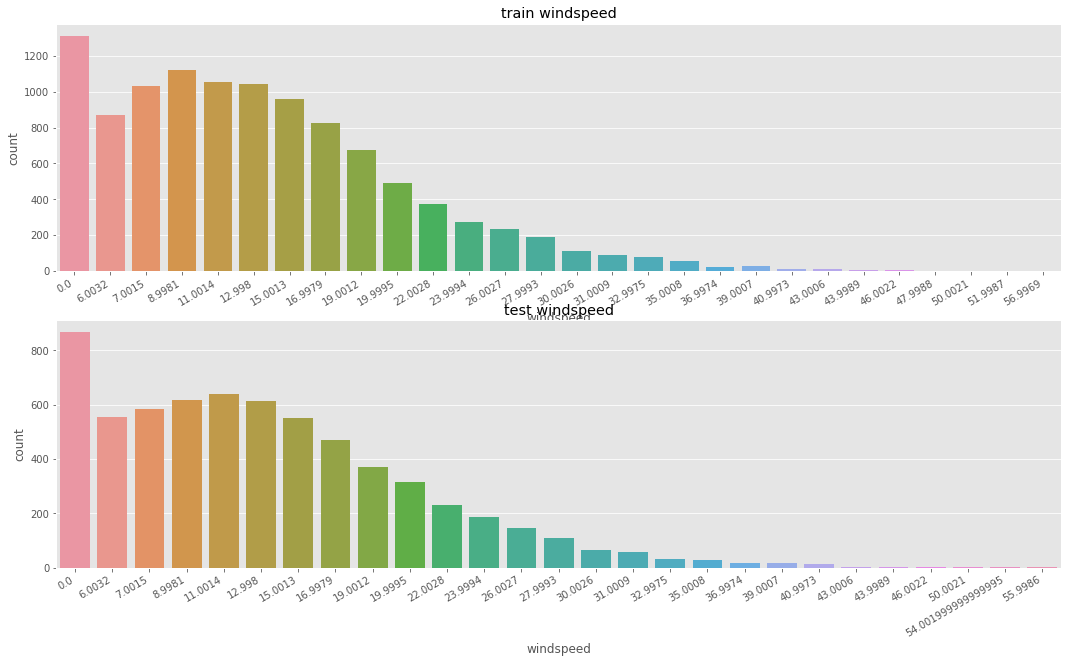

In [22]:
# widspeed 풍속에 0 값이 가장 많다. => 잘못 기록된 데이터를 고쳐 줄 필요가 있음
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [23]:
# 풍속의 0값에 특정 값을 넣어준다.
# 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.
# train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
# test.loc[train["windspeed"] == 0, "windspeed"] = test["windspeed"].mean()

In [24]:
# 풍속이 0인것과 아닌 것의 세트를 나누어 준다.
trainWind0 = test.loc[test['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(867, 16)
(9573, 20)


In [25]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

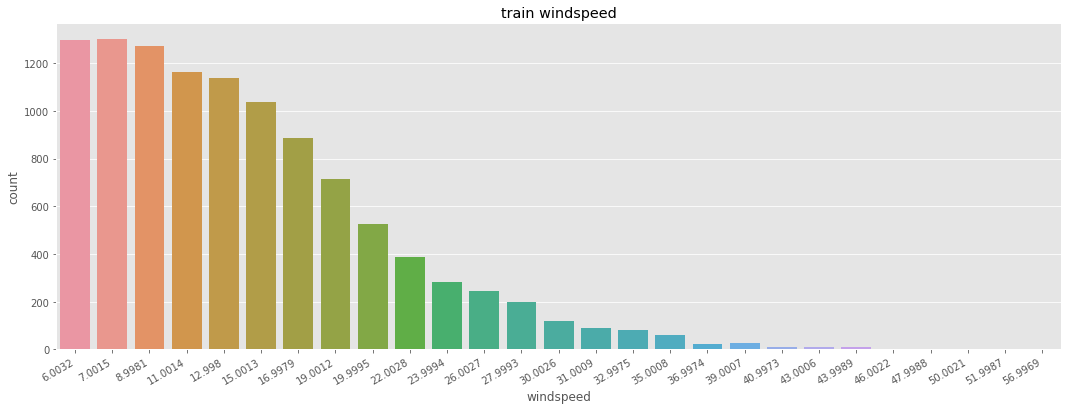

In [26]:
# 0값을 조정한다.
train = predict_windspeed(train)
# test = predict_windspeed(test)

# widspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

# Feature Selection
- 신호와 잡음을 구분해야 한다.
- 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다.
- 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [27]:
#연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [28]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [29]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [31]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [32]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# Score
RMSLE

In [33]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [34]:
#Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [35]:
#RandomForest
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [36]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

CPU times: user 3.19 s, sys: 697 ms, total: 3.89 s
Wall time: 30.4 s
Score= 0.33102


#train

In [47]:
# 학습시킴, 피팅(옷을 맞출 때 사용하는 피팅을 생각함) - 피처와 레이블을 넣어주면 알아서 학습을 함
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [48]:
#예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.6 ,   5.15,   4.15,   3.47,   3.23,   6.41,  38.32, 106.06,
       236.92, 136.33])

[Text(0.5, 1.0, 'test')]

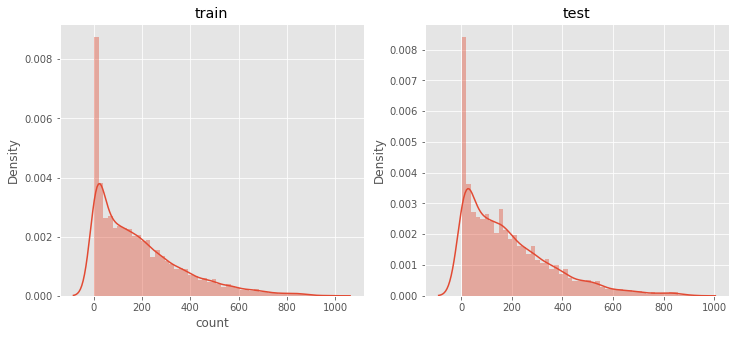

In [49]:
# 예측한 데이터를 시각화 해본다. 
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test")